# Data exploration and processing

In [1]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import splitfolders

In [2]:
RND_SEED = 88

original_data_path = "data/PetImages"
split_data_path = "data/splitPetImages"

cat_dir = os.path.join(original_data_path, "Cat")
dog_dir = os.path.join(original_data_path, "Dog")

Total images: 25002
Cats: 12501 (50.0%)
Dogs: 12501 (50.0%)


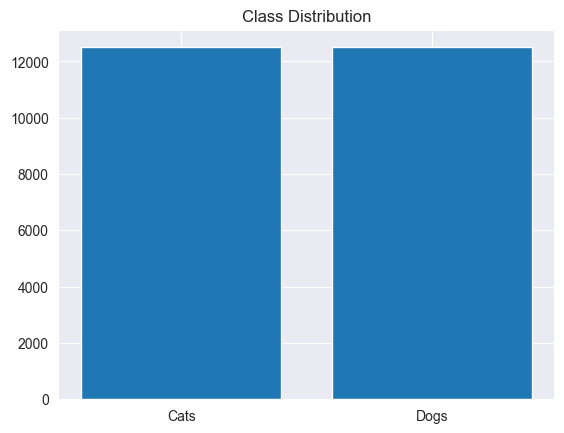

In [3]:
# Check class distribution
num_cats = len(os.listdir(cat_dir))
num_dogs = len(os.listdir(dog_dir))
total = num_cats + num_dogs

print(f"Total images: {total}")
print(f"Cats: {num_cats} ({num_cats/total:.1%})")
print(f"Dogs: {num_dogs} ({num_dogs/total:.1%})")

plt.bar(['Cats', 'Dogs'], [num_cats, num_dogs])
plt.title('Class Distribution')
plt.show()

the data is perfectly balanced

In [4]:
# Show sample images with original dimensions
def plot_sample_images(class_dir, class_name, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Sample {class_name} images with original dimensions")
    images = random.sample(os.listdir(class_dir), num_samples)
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f"Shape: {img.size}")
            plt.axis('off')
        except:
            continue
    plt.show()

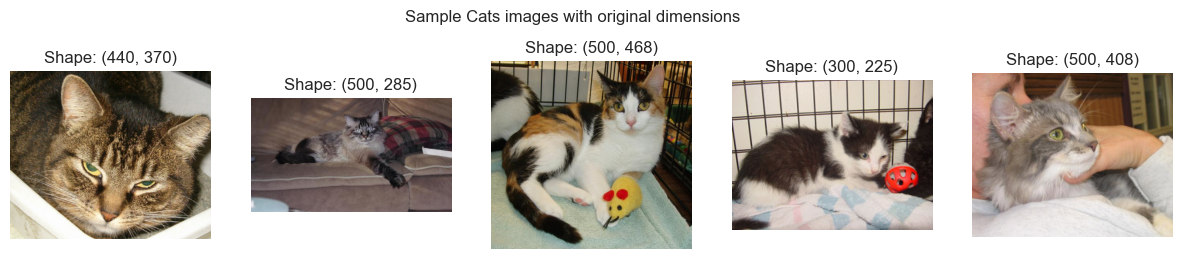

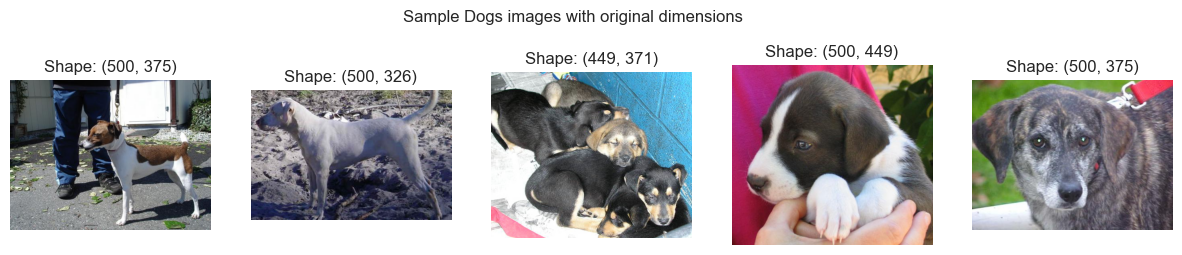

In [5]:
plot_sample_images(cat_dir, "Cats")
plot_sample_images(dog_dir, "Dogs")

In [6]:
# Create split directories and split data
splitfolders.ratio(
    original_data_path,
    output=split_data_path,
    seed=RND_SEED,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None,
    move=False
)

Copying files: 25002 files [00:26, 940.56 files/s] 


In [7]:
# Verify splits
def verify_split(split_path):
    print(f"\nVerifying {split_path}:")
    cat_path = os.path.join(split_path, "Cat")
    dog_path = os.path.join(split_path, "Dog")
    print(f"Cats: {len(os.listdir(cat_path))} images")
    print(f"Dogs: {len(os.listdir(dog_path))} images")

In [8]:
verify_split(os.path.join(split_data_path, "train"))
verify_split(os.path.join(split_data_path, "val"))
verify_split(os.path.join(split_data_path, "test"))


Verifying data/splitPetImages\train:
Cats: 10000 images
Dogs: 10000 images

Verifying data/splitPetImages\val:
Cats: 1250 images
Dogs: 1250 images

Verifying data/splitPetImages\test:
Cats: 1251 images
Dogs: 1251 images


In [9]:
# CHeck and remove corrupt images from splits
def remove_corrupt_images(split_dir):
    corrupt_count = 0
    for root, dirs, files in os.walk(split_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.load()
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupt file: {file_path}")
                os.remove(file_path)
                corrupt_count += 1
    print(f"Removed {corrupt_count} corrupt images from {split_dir}")

In [10]:
for split in ["train", "val", "test"]:
    remove_corrupt_images(os.path.join(split_data_path, split))

Removing corrupt file: data/splitPetImages\train\Cat\666.jpg
Removing corrupt file: data/splitPetImages\train\Cat\Thumbs.db
Removing corrupt file: data/splitPetImages\train\Dog\11702.jpg


C:\Users\ruier\Documents\GitHub\ML-IVU-project-2024\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removing corrupt file: data/splitPetImages\train\Dog\Thumbs.db
Removed 4 corrupt images from data/splitPetImages\train
Removed 0 corrupt images from data/splitPetImages\val
Removed 0 corrupt images from data/splitPetImages\test


In [11]:
# train validation test data paths
train_dir = os.path.join(split_data_path, "train")
val_dir = os.path.join(split_data_path, "val")
test_dir = os.path.join(split_data_path, "test")

In [12]:
# Create data loaders with augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # RandomCrop + Resize 224x224 but better
    transforms.RandomHorizontalFlip(),  # default is 50%, cats/dogs can face either direction
    transforms.RandomRotation(20),  # Adds robustness to camera angle variations
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Simulates different lighting conditions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
def show_data_batch(dataloader):
    images, labels = next(iter(dataloader))

    # Create inverse normalization transform
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(images))):
        img = inv_normalize(images[i]) # Denormalize
        plt.subplot(1, 5, i+1)
        plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
        plt.title(f"Label: {['Cat', 'Dog'][labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Training batch samples:


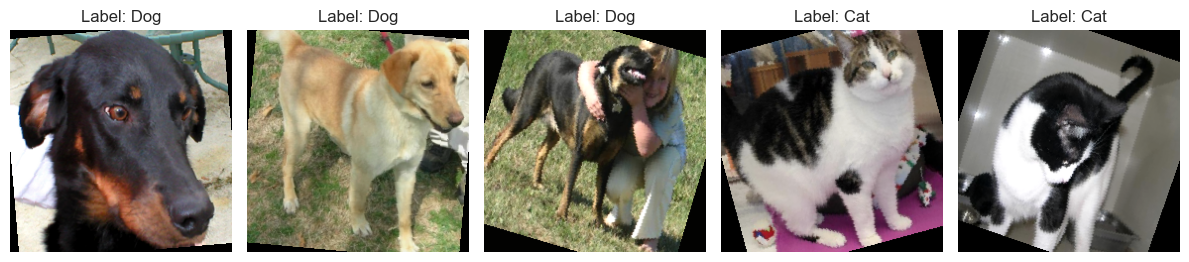


Validation batch samples:


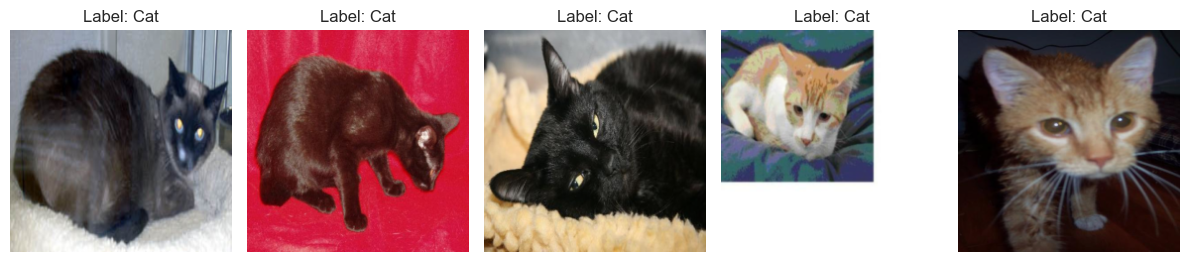

In [14]:
print("Training batch samples:")
show_data_batch(train_loader)

print("\nValidation batch samples:")
show_data_batch(val_loader)

In [15]:
print(f"\nDataset Sizes:")
print(f"Training: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")

def check_class_balance(split_path):
    cat = len(os.listdir(os.path.join(split_path, 'Cat')))
    dog = len(os.listdir(os.path.join(split_path, 'Dog')))
    return f"Cat: {cat} ({cat/(cat+dog):.1%}), Dog: {dog} ({dog/(cat+dog):.1%})"

print("\nClass Balance:")
print(f"Train: {check_class_balance(train_dir)}")
print(f"Val: {check_class_balance(val_dir)}")
print(f"Test: {check_class_balance(test_dir)}")


Dataset Sizes:
Training: 19996 images
Validation: 2500 images
Test: 2502 images

Class Balance:
Train: Cat: 9998 (50.0%), Dog: 9998 (50.0%)
Val: Cat: 1250 (50.0%), Dog: 1250 (50.0%)
Test: Cat: 1251 (50.0%), Dog: 1251 (50.0%)


In [16]:
# Visualization of data augmentation on sample
def plot_augmentations(image_path, transform, num_augs=5):
    original = Image.open(image_path)

    plt.figure(figsize=(15, 3))
    plt.suptitle("Augmentation Examples", y=1.1)

    plt.subplot(1, num_augs + 1, 1)
    plt.imshow(original)
    plt.title(f"Original\nSize: {original.size}")
    plt.axis('off')

    # Apply demo transform multiple times
    for i in range(num_augs):
        augmented = transform(original)
        to_pil = transforms.ToPILImage()
        augmented_pil = to_pil(augmented)

        plt.subplot(1, num_augs + 1, i + 2)
        plt.imshow(augmented_pil)
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Cat augmentations:


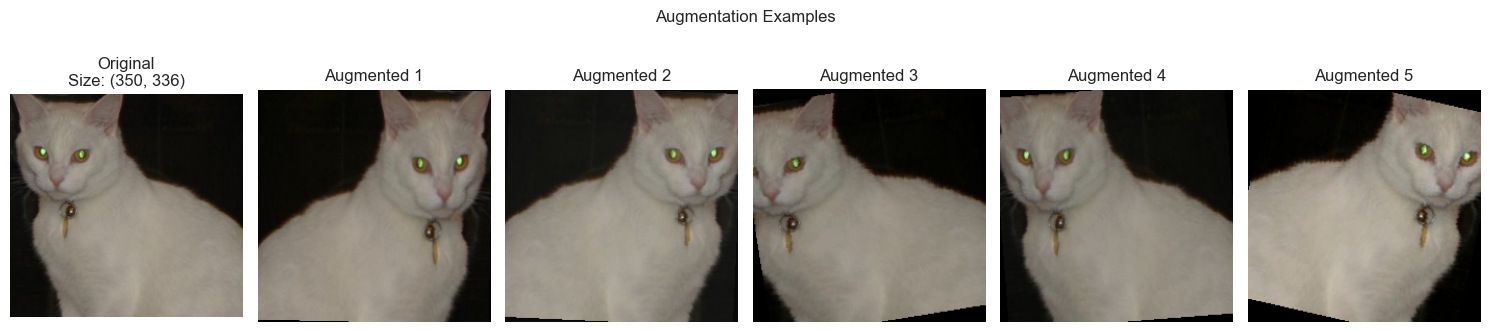


Dog augmentations:


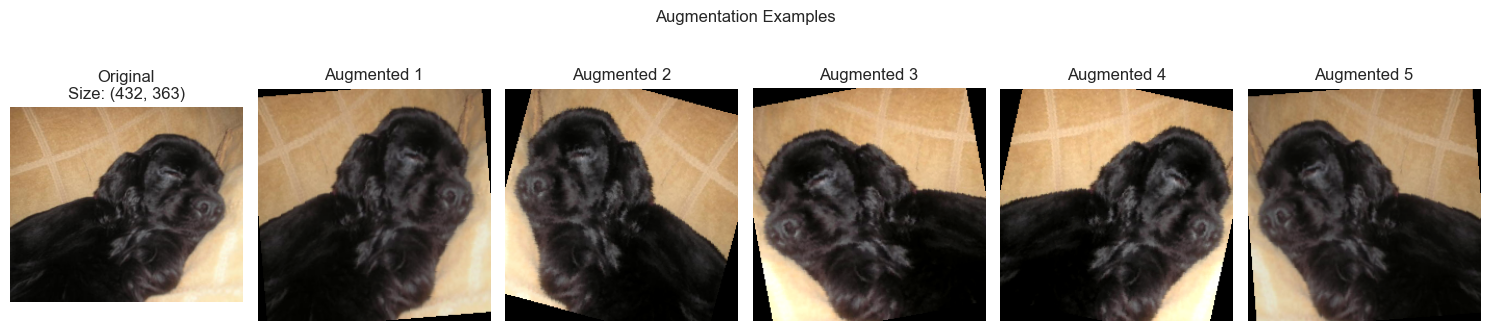

In [59]:
demo_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
])

# sample images
sample_cat = os.path.join(cat_dir, os.listdir(cat_dir)[30])
sample_dog = os.path.join(dog_dir, os.listdir(dog_dir)[30])

print("Cat augmentations:")
plot_augmentations(sample_cat, demo_transform)

print("\nDog augmentations:")
plot_augmentations(sample_dog, demo_transform)

# MODEL

In [18]:
import torch
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from model import ResNetBinaryClassifier

In [19]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.6.0+cu126
True
NVIDIA GeForce RTX 4070 SUPER


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [21]:
# Check image dimensions: All images should be of size (3, 224, 224)
def check_dims(dataset):
    sizes = []
    for img, _ in dataset:
        if img is not None:
            sizes.append(img.shape)
    unique_sizes = set(sizes)
    print(f"Found {len(unique_sizes)} unique sizes")

# print("\nTraining set dimensions:")
# check_dims(train_dataset)

In [22]:
# # Define the model -> moved to .py file
# class ResNetBinaryClassifier(nn.Module):
#     def __init__(self, freeze_base=True):
#         super().__init__()
#         self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
#
#         # Freeze ALL base layers by default
#         if freeze_base:
#             for param in self.resnet.parameters():
#                 param.requires_grad = False
#
#         # Replace final layer
#         num_features = self.resnet.fc.in_features
#         self.resnet.fc = nn.Sequential(
#             nn.Linear(num_features, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 1)
#         )
#
#     def forward(self, x):
#         return torch.sigmoid(self.resnet(x))

In [23]:
# resnet50 architecture
# models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [24]:
# Define model
model = ResNetBinaryClassifier().to(device)

In [25]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=1e-5) # L2 regularization: learning rate maybe 10^-4 = 0.0001

In [26]:
# Training and validation
def train_model(model, criterion, optimizer, num_epochs=15):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)  # Predicted probabilities
            # Loss calculation
            loss = criterion(outputs, labels)  # BCELoss between preds and true labels
            # Backpropagation
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights

            running_loss += loss.item() * inputs.size(0)
            # Accuracy tracking (>0.5 threshold)
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 class labels (0 cat, 1 dog)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.5).float()
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_dataset)

        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        # Save best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}\n')

    return history

In [28]:
history = train_model(model, criterion, optimizer, num_epochs=30)

Epoch 1/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.31it/s]



Epoch 1/30
Train Loss: 0.2740 Acc: 0.9606
Val Loss: 0.1658 Acc: 0.9792



Epoch 2/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.35it/s]



Epoch 2/30
Train Loss: 0.1524 Acc: 0.9683
Val Loss: 0.1027 Acc: 0.9812



Epoch 3/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.60it/s]



Epoch 3/30
Train Loss: 0.1121 Acc: 0.9722
Val Loss: 0.0759 Acc: 0.9852



Epoch 4/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.75it/s]



Epoch 4/30
Train Loss: 0.0924 Acc: 0.9739
Val Loss: 0.0602 Acc: 0.9876



Epoch 5/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.76it/s]



Epoch 5/30
Train Loss: 0.0791 Acc: 0.9770
Val Loss: 0.0536 Acc: 0.9880



Epoch 6/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.75it/s]



Epoch 6/30
Train Loss: 0.0734 Acc: 0.9765
Val Loss: 0.0487 Acc: 0.9876



Epoch 7/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.71it/s]



Epoch 7/30
Train Loss: 0.0662 Acc: 0.9782
Val Loss: 0.0422 Acc: 0.9912



Epoch 8/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.58it/s]



Epoch 8/30
Train Loss: 0.0614 Acc: 0.9803
Val Loss: 0.0405 Acc: 0.9900



Epoch 9/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.91it/s]



Epoch 9/30
Train Loss: 0.0609 Acc: 0.9787
Val Loss: 0.0385 Acc: 0.9912



Epoch 10/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.80it/s]



Epoch 10/30
Train Loss: 0.0567 Acc: 0.9807
Val Loss: 0.0370 Acc: 0.9908



Epoch 11/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.72it/s]



Epoch 11/30
Train Loss: 0.0541 Acc: 0.9819
Val Loss: 0.0346 Acc: 0.9908



Epoch 12/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.86it/s]



Epoch 12/30
Train Loss: 0.0519 Acc: 0.9814
Val Loss: 0.0337 Acc: 0.9916



Epoch 13/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.78it/s]



Epoch 13/30
Train Loss: 0.0514 Acc: 0.9819
Val Loss: 0.0336 Acc: 0.9896



Epoch 14/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.98it/s]



Epoch 14/30
Train Loss: 0.0487 Acc: 0.9834
Val Loss: 0.0315 Acc: 0.9912



Epoch 15/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.95it/s]



Epoch 15/30
Train Loss: 0.0479 Acc: 0.9836
Val Loss: 0.0306 Acc: 0.9908



Epoch 16/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.90it/s]



Epoch 16/30
Train Loss: 0.0461 Acc: 0.9832
Val Loss: 0.0314 Acc: 0.9908



Epoch 17/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.83it/s]



Epoch 17/30
Train Loss: 0.0472 Acc: 0.9833
Val Loss: 0.0298 Acc: 0.9908



Epoch 18/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 13.02it/s]



Epoch 18/30
Train Loss: 0.0449 Acc: 0.9834
Val Loss: 0.0307 Acc: 0.9916



Epoch 19/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.80it/s]



Epoch 19/30
Train Loss: 0.0461 Acc: 0.9821
Val Loss: 0.0289 Acc: 0.9916



Epoch 20/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]



Epoch 20/30
Train Loss: 0.0460 Acc: 0.9832
Val Loss: 0.0283 Acc: 0.9912



Epoch 21/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.85it/s]



Epoch 21/30
Train Loss: 0.0442 Acc: 0.9841
Val Loss: 0.0282 Acc: 0.9920



Epoch 22/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.77it/s]



Epoch 22/30
Train Loss: 0.0415 Acc: 0.9854
Val Loss: 0.0285 Acc: 0.9916



Epoch 23/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.95it/s]



Epoch 23/30
Train Loss: 0.0432 Acc: 0.9852
Val Loss: 0.0269 Acc: 0.9932



Epoch 24/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.91it/s]



Epoch 24/30
Train Loss: 0.0408 Acc: 0.9860
Val Loss: 0.0271 Acc: 0.9920



Epoch 25/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.73it/s]



Epoch 25/30
Train Loss: 0.0406 Acc: 0.9848
Val Loss: 0.0276 Acc: 0.9916



Epoch 26/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.56it/s]



Epoch 26/30
Train Loss: 0.0404 Acc: 0.9856
Val Loss: 0.0266 Acc: 0.9920



Epoch 27/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.74it/s]



Epoch 27/30
Train Loss: 0.0397 Acc: 0.9862
Val Loss: 0.0265 Acc: 0.9920



Epoch 28/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.69it/s]



Epoch 28/30
Train Loss: 0.0393 Acc: 0.9854
Val Loss: 0.0259 Acc: 0.9928



Epoch 29/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.93it/s]



Epoch 29/30
Train Loss: 0.0420 Acc: 0.9857
Val Loss: 0.0259 Acc: 0.9924



Epoch 30/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Epoch 30/30
Train Loss: 0.0383 Acc: 0.9861
Val Loss: 0.0270 Acc: 0.9912



In [29]:
# Plot training history
def plot_training_history(history, title="Training and Validation Performance", highlight_best=False):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')

    if highlight_best:
        best_epoch = np.argmin(history['val_loss']) + 1
        plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch})')

    plt.xticks(range(1, len(train_acc) + 1))
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

    if highlight_best:
        plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch})')

    plt.xticks(range(1, len(train_loss) + 1))
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

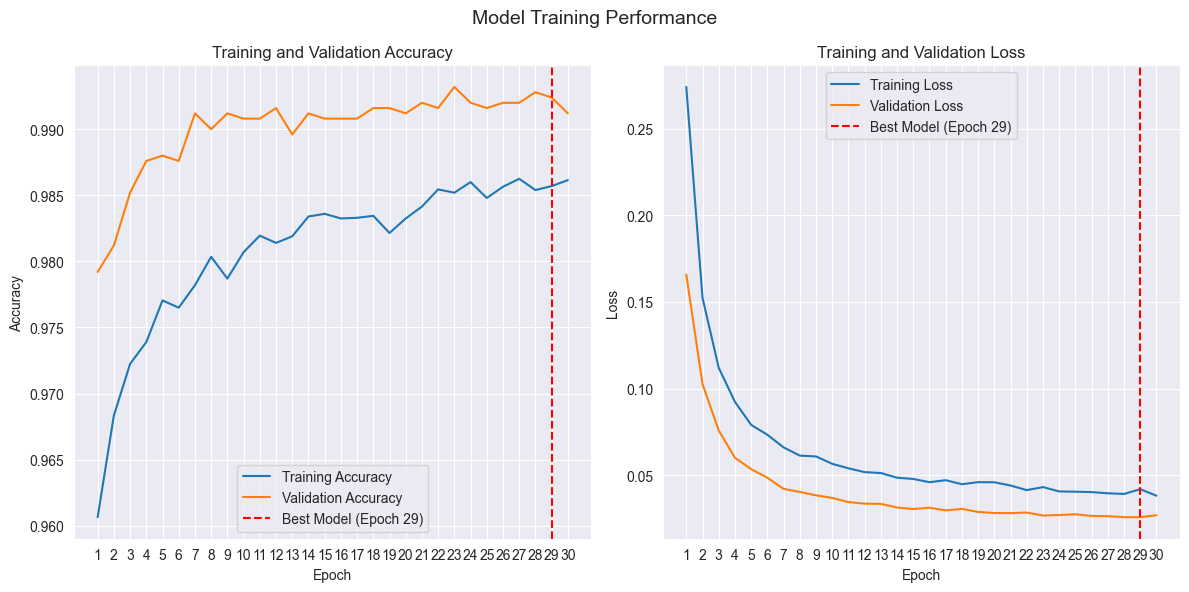

In [30]:
plot_training_history(history, title="Model Training Performance", highlight_best=True)

In [31]:
# Evaluation on test set
def evaluate_model(model, test_loader, device):
    model.eval()

    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_probs = []

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

            # Get misclassified images
            misclassified_mask = (preds != labels).squeeze()
            misclassified_batch = inputs[misclassified_mask]  # Misclassified images
            misclassified_labels = labels[misclassified_mask].cpu().numpy()  # True labels
            misclassified_preds = preds[misclassified_mask].cpu().numpy()  # Predicted labels
            misclassified_probs_batch = outputs[misclassified_mask.cpu().numpy()]  # Probabilities

            for img, true_label, pred_label, prob in zip(misclassified_batch, misclassified_labels, misclassified_preds, misclassified_probs_batch):
                misclassified_images.append((img.cpu(), int(true_label.item()), int(pred_label.item())))
                misclassified_probs.append(prob)

    test_acc = correct.double() / total
    print(f'Test Accuracy: {test_acc:.2%}')
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Cat', 'Dog']))
    print('\nConfusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(2), ['Cat', 'Dog'])
    plt.yticks(np.arange(2), ['Cat', 'Dog'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

    # Accuracy per class
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f"Accuracy per class: Cat: {class_accuracy[0]:.2%}, Dog: {class_accuracy[1]:.2%}")

    return test_acc.item(), cm, misclassified_images, misclassified_probs

Test Accuracy: 99.04%

Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      1251
         Dog       0.99      0.99      0.99      1251

    accuracy                           0.99      2502
   macro avg       0.99      0.99      0.99      2502
weighted avg       0.99      0.99      0.99      2502


Confusion Matrix:
[[1237   14]
 [  10 1241]]


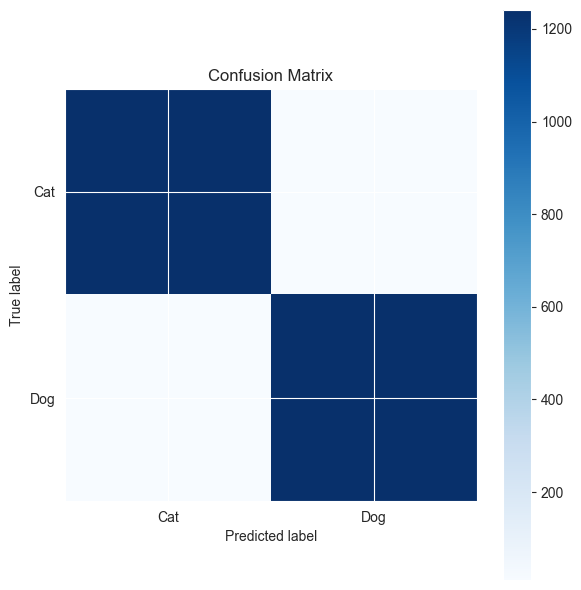

Accuracy per class: Cat: 98.88%, Dog: 99.20%


In [32]:
model.load_state_dict(torch.load('best_model.pth'))
test_acc, cm, misclassified_images, misclassified_probs = evaluate_model(model, test_loader, device)

In [70]:
# Function to visualize misclassified images
def plot_misclassified_images(misclassified_images, misclassified_probs):
    if not misclassified_images:
        print("No misclassified images found!")
        return

    num_images = len(misclassified_images)
    class_names = ['Cat', 'Dog']

    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(12, 3 * num_rows))  # Dynamically adjust height

    for i in range(num_images):
        img, true_label, pred_label = misclassified_images[i]
        prob = misclassified_probs[i]

        # Inverse normalization
        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img = inv_normalize(img).clamp(0, 1)
        img_resized = transforms.functional.resize(img, (224, 224))

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_resized.permute(1, 2, 0))

        prob_dog = prob[0]  # Probability for class Dog
        prob_cat = 1 - prob_dog  # Probability for class Cat
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nProb: Dog {prob_dog:.2%}, Cat {prob_cat:.2%}")

        plt.axis('off')

    plt.tight_layout()
    plt.show()

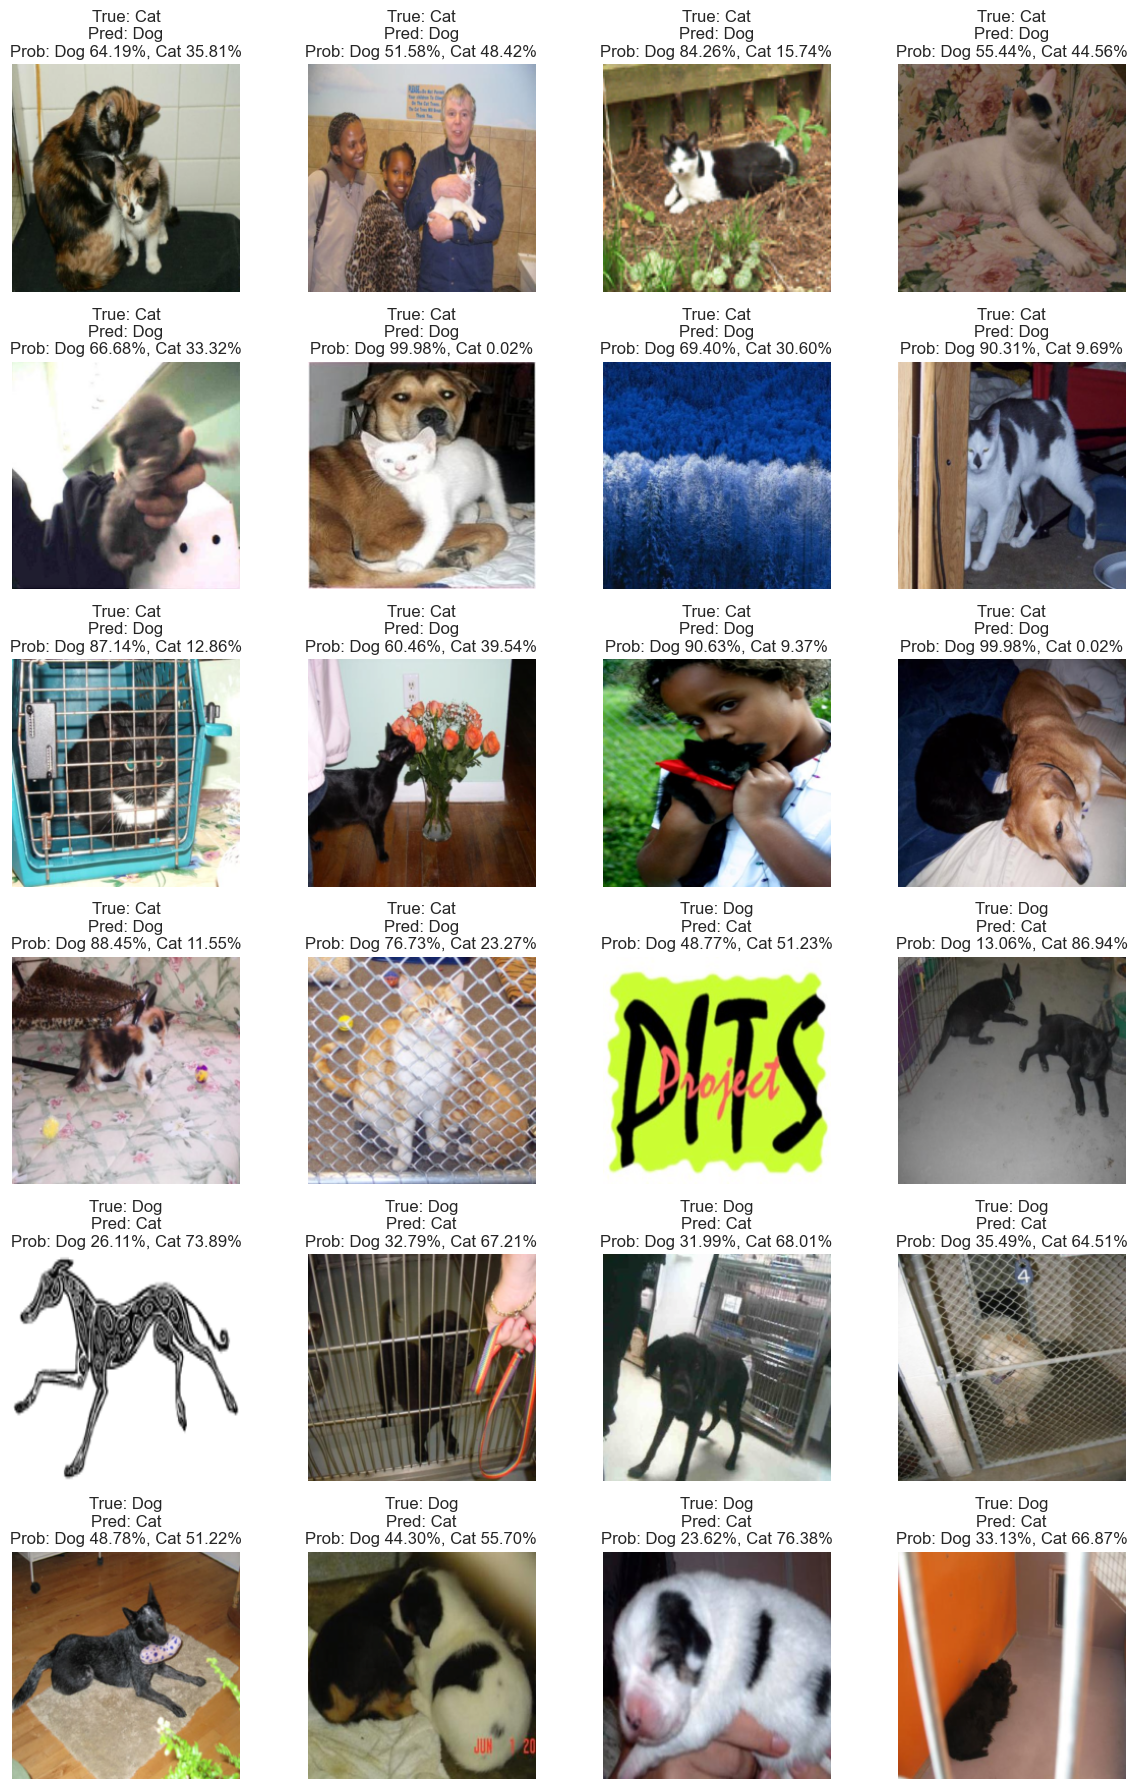

In [71]:
plot_misclassified_images(misclassified_images, misclassified_probs)
# image 11184

## Fine tune model

In [35]:
def unfreeze_layers(model, num_unfreeze=10):
    # Unfreeze last num_unfreeze layers
    children = list(model.resnet.children())
    for child in children[-num_unfreeze:]:
        for param in child.parameters():
            param.requires_grad = True
    return model

In [37]:
# Fine-tuning
model_ft = ResNetBinaryClassifier(freeze_base=True)
model_ft = unfreeze_layers(model_ft, num_unfreeze=10).to(device)

# Smaller learning rate for fine-tuning
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-6)

print("\nStarting fine-tuning...")
history_fine = train_model(model_ft, criterion, optimizer_ft, num_epochs=30)

torch.save(model_ft.state_dict(), 'best_model_fine.pth')


Starting fine-tuning...


Epoch 1/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.33it/s]



Epoch 1/30
Train Loss: 0.6525 Acc: 0.7084
Val Loss: 0.5682 Acc: 0.9028



Epoch 2/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.34it/s]



Epoch 2/30
Train Loss: 0.4742 Acc: 0.8914
Val Loss: 0.3873 Acc: 0.9648



Epoch 3/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.46it/s]



Epoch 3/30
Train Loss: 0.3361 Acc: 0.9615
Val Loss: 0.2643 Acc: 0.9860



Epoch 4/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.35it/s]



Epoch 4/30
Train Loss: 0.2111 Acc: 0.9786
Val Loss: 0.1404 Acc: 0.9908



Epoch 5/30 - Validation: 100%|██████████| 79/79 [00:06<00:00, 13.12it/s]



Epoch 5/30
Train Loss: 0.1227 Acc: 0.9823
Val Loss: 0.0803 Acc: 0.9908



Epoch 6/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.37it/s]



Epoch 6/30
Train Loss: 0.0825 Acc: 0.9838
Val Loss: 0.0541 Acc: 0.9928



Epoch 7/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.43it/s]



Epoch 7/30
Train Loss: 0.0650 Acc: 0.9845
Val Loss: 0.0425 Acc: 0.9924



Epoch 8/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.37it/s]



Epoch 8/30
Train Loss: 0.0528 Acc: 0.9864
Val Loss: 0.0355 Acc: 0.9920



Epoch 9/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.29it/s]



Epoch 9/30
Train Loss: 0.0444 Acc: 0.9879
Val Loss: 0.0294 Acc: 0.9940



Epoch 10/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.44it/s]



Epoch 10/30
Train Loss: 0.0401 Acc: 0.9886
Val Loss: 0.0254 Acc: 0.9944



Epoch 11/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.34it/s]



Epoch 11/30
Train Loss: 0.0390 Acc: 0.9876
Val Loss: 0.0233 Acc: 0.9944



Epoch 12/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.41it/s]



Epoch 12/30
Train Loss: 0.0323 Acc: 0.9907
Val Loss: 0.0244 Acc: 0.9916



Epoch 13/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.44it/s]



Epoch 13/30
Train Loss: 0.0335 Acc: 0.9885
Val Loss: 0.0227 Acc: 0.9924



Epoch 14/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.39it/s]



Epoch 14/30
Train Loss: 0.0300 Acc: 0.9900
Val Loss: 0.0177 Acc: 0.9964



Epoch 15/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.34it/s]



Epoch 15/30
Train Loss: 0.0279 Acc: 0.9905
Val Loss: 0.0170 Acc: 0.9960



Epoch 16/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.34it/s]



Epoch 16/30
Train Loss: 0.0276 Acc: 0.9908
Val Loss: 0.0213 Acc: 0.9924



Epoch 17/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.33it/s]



Epoch 17/30
Train Loss: 0.0263 Acc: 0.9913
Val Loss: 0.0185 Acc: 0.9948



Epoch 18/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.38it/s]



Epoch 18/30
Train Loss: 0.0248 Acc: 0.9913
Val Loss: 0.0158 Acc: 0.9956



Epoch 19/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.42it/s]



Epoch 19/30
Train Loss: 0.0265 Acc: 0.9909
Val Loss: 0.0153 Acc: 0.9956



Epoch 20/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.25it/s]



Epoch 20/30
Train Loss: 0.0238 Acc: 0.9921
Val Loss: 0.0160 Acc: 0.9952



Epoch 21/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.33it/s]



Epoch 21/30
Train Loss: 0.0228 Acc: 0.9923
Val Loss: 0.0126 Acc: 0.9964



Epoch 22/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.38it/s]



Epoch 22/30
Train Loss: 0.0225 Acc: 0.9928
Val Loss: 0.0135 Acc: 0.9968



Epoch 23/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.45it/s]



Epoch 23/30
Train Loss: 0.0202 Acc: 0.9929
Val Loss: 0.0124 Acc: 0.9960



Epoch 24/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.36it/s]



Epoch 24/30
Train Loss: 0.0204 Acc: 0.9930
Val Loss: 0.0115 Acc: 0.9968



Epoch 25/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.38it/s]



Epoch 25/30
Train Loss: 0.0197 Acc: 0.9925
Val Loss: 0.0121 Acc: 0.9968



Epoch 26/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.43it/s]



Epoch 26/30
Train Loss: 0.0201 Acc: 0.9934
Val Loss: 0.0107 Acc: 0.9972



Epoch 27/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.31it/s]



Epoch 27/30
Train Loss: 0.0180 Acc: 0.9938
Val Loss: 0.0146 Acc: 0.9960



Epoch 28/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.34it/s]



Epoch 28/30
Train Loss: 0.0174 Acc: 0.9939
Val Loss: 0.0116 Acc: 0.9968



Epoch 29/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.42it/s]



Epoch 29/30
Train Loss: 0.0159 Acc: 0.9945
Val Loss: 0.0108 Acc: 0.9968



Epoch 30/30 - Validation: 100%|██████████| 79/79 [00:05<00:00, 13.39it/s]



Epoch 30/30
Train Loss: 0.0177 Acc: 0.9944
Val Loss: 0.0111 Acc: 0.9976



In [38]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Trainable: resnet.conv1.weight
Trainable: resnet.bn1.weight
Trainable: resnet.bn1.bias
Trainable: resnet.layer1.0.conv1.weight
Trainable: resnet.layer1.0.bn1.weight
Trainable: resnet.layer1.0.bn1.bias
Trainable: resnet.layer1.0.conv2.weight
Trainable: resnet.layer1.0.bn2.weight
Trainable: resnet.layer1.0.bn2.bias
Trainable: resnet.layer1.0.conv3.weight
Trainable: resnet.layer1.0.bn3.weight
Trainable: resnet.layer1.0.bn3.bias
Trainable: resnet.layer1.0.downsample.0.weight
Trainable: resnet.layer1.0.downsample.1.weight
Trainable: resnet.layer1.0.downsample.1.bias
Trainable: resnet.layer1.1.conv1.weight
Trainable: resnet.layer1.1.bn1.weight
Trainable: resnet.layer1.1.bn1.bias
Trainable: resnet.layer1.1.conv2.weight
Trainable: resnet.layer1.1.bn2.weight
Trainable: resnet.layer1.1.bn2.bias
Trainable: resnet.layer1.1.conv3.weight
Trainable: resnet.layer1.1.bn3.weight
Trainable: resnet.layer1.1.bn3.bias
Trainable: resnet.layer1.2.conv1.weight
Trainable: resnet.layer1.2.bn1.weight
Trainable: r

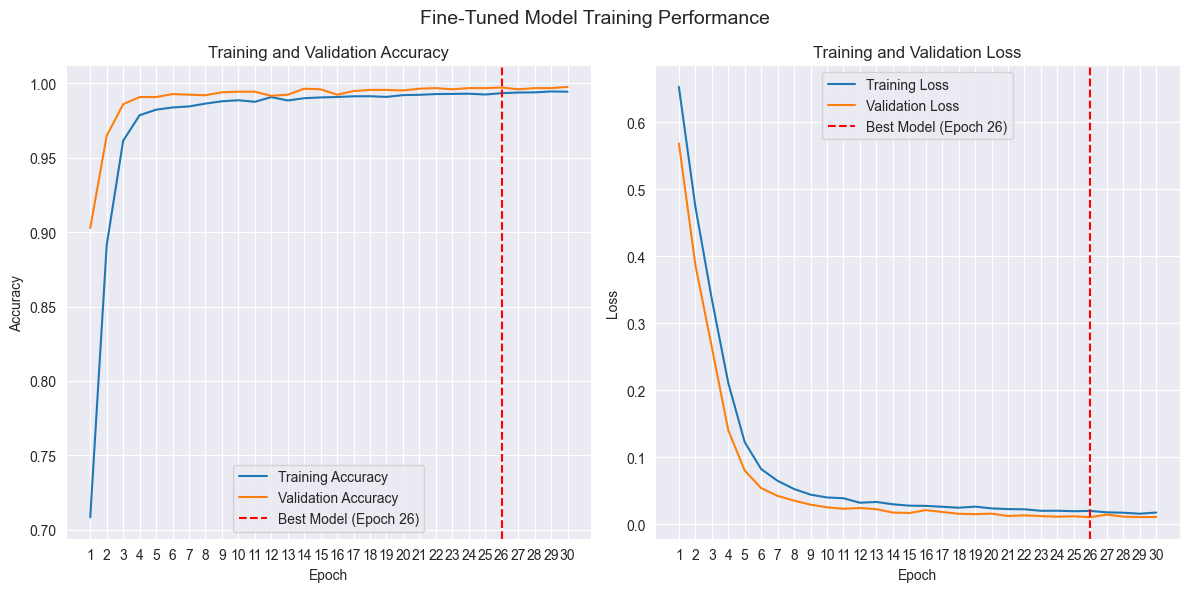

In [39]:
# Plot fine-tuned model training
plot_training_history(history_fine, title="Fine-Tuned Model Training Performance", highlight_best=True)

Test Accuracy: 99.40%

Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      1251
         Dog       0.99      0.99      0.99      1251

    accuracy                           0.99      2502
   macro avg       0.99      0.99      0.99      2502
weighted avg       0.99      0.99      0.99      2502


Confusion Matrix:
[[1244    7]
 [   8 1243]]


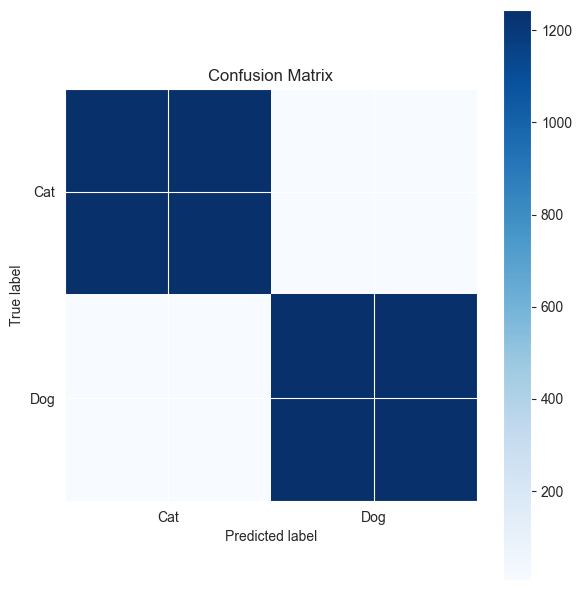

Accuracy per class: Cat: 99.44%, Dog: 99.36%


In [40]:
# Evaluate fine-tuned model
model_ft.load_state_dict(torch.load('best_model_fine.pth'))
fine_test_acc, fine_cm, fine_misclassified_images, fine_misclassified_probs = evaluate_model(model_ft, test_loader, device)

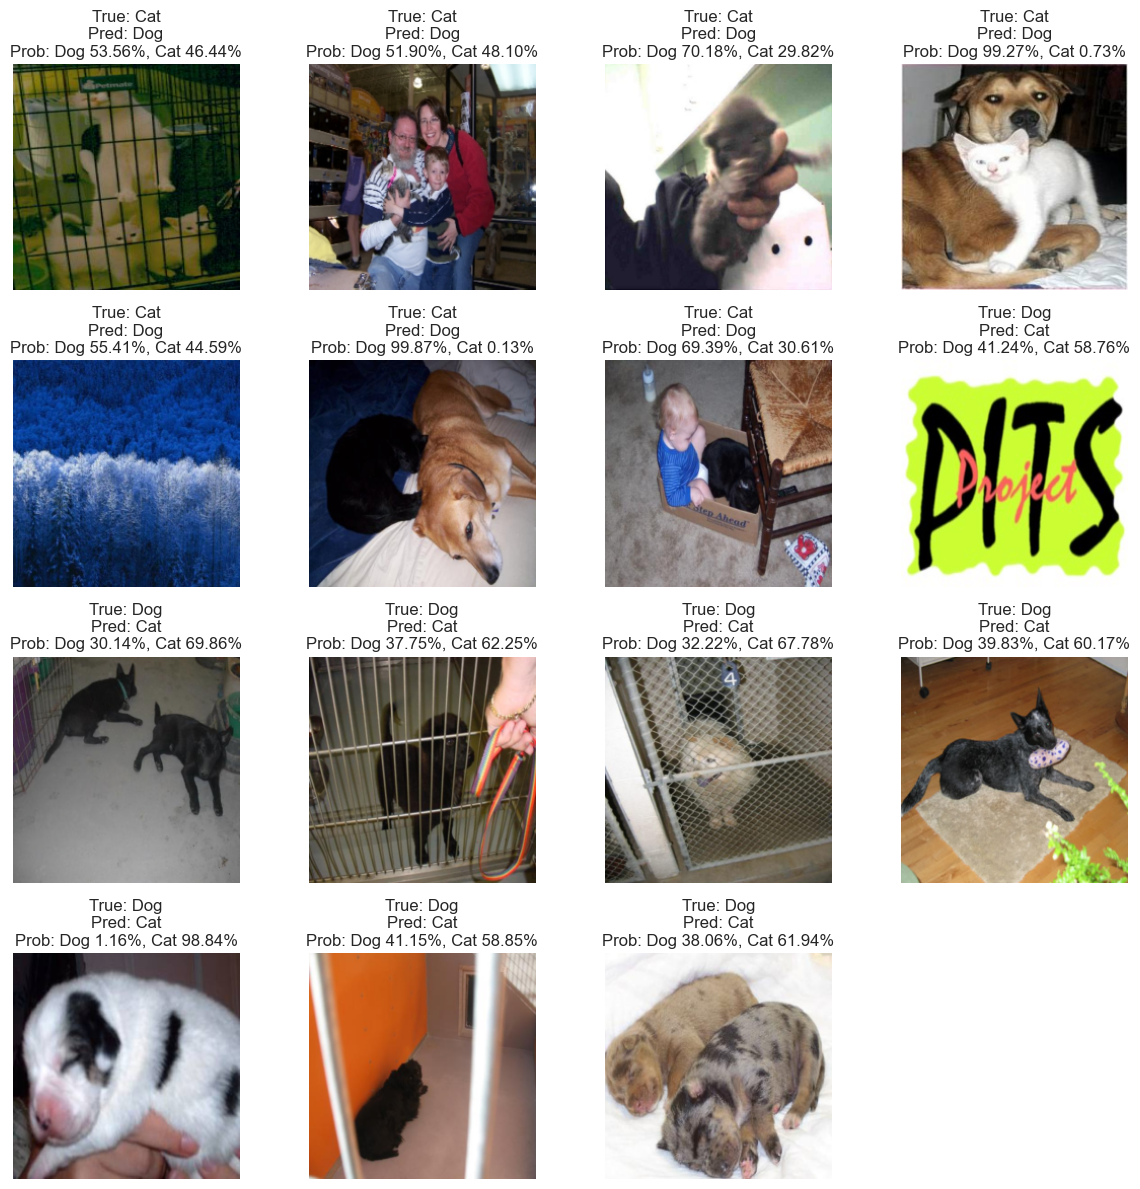

In [72]:
# Visualize misclassified images:
plot_misclassified_images(fine_misclassified_images, fine_misclassified_probs)

## Comparison

In [55]:
from tabulate import tabulate

# Function to compare the initial and fine-tuned models' metrics
def compare_metrics(initial_metrics, fine_metrics):
    headers = ["Metric", "Initial", "Fine-tuned", "Change"]
    table = []

    initial_acc = initial_metrics.get("Test Accuracy", 0)
    fine_acc = fine_metrics.get("Test Accuracy", 0)
    table.append(["Test Accuracy", f"{initial_acc:.2%}", f"{fine_acc:.2%}", f"{fine_acc - initial_acc:+.2%}"])

    initial_class_acc = initial_metrics.get("Class Accuracy", [0, 0])
    fine_class_acc = fine_metrics.get("Class Accuracy", [0, 0])

    table.append(["Cat Accuracy", f"{initial_class_acc[0]:.2%}", f"{fine_class_acc[0]:.2%}", f"{fine_class_acc[0] - initial_class_acc[0]:+.2%}"])
    table.append(["Dog Accuracy", f"{initial_class_acc[1]:.2%}", f"{fine_class_acc[1]:.2%}", f"{fine_class_acc[1] - initial_class_acc[1]:+.2%}"])

    print("\nModel Comparison")
    print(tabulate(table, headers=headers, tablefmt="grid"))

In [56]:
initial_metrics = {
    'Test Accuracy': test_acc,
    'Class Accuracy': cm.diagonal() / cm.sum(axis=1)  # Class-wise accuracy
}

fine_metrics = {
    'Test Accuracy': fine_test_acc,
    'Class Accuracy': fine_cm.diagonal() / fine_cm.sum(axis=1)  # Class-wise accuracy
}

In [57]:
compare_metrics(initial_metrics, fine_metrics)


Model Comparison
+---------------+-----------+--------------+----------+
| Metric        | Initial   | Fine-tuned   | Change   |
+===============+===========+==============+==========+
| Test Accuracy | 99.04%    | 99.40%       | +0.36%   |
+---------------+-----------+--------------+----------+
| Cat Accuracy  | 98.88%    | 99.44%       | +0.56%   |
+---------------+-----------+--------------+----------+
| Dog Accuracy  | 99.20%    | 99.36%       | +0.16%   |
+---------------+-----------+--------------+----------+
